# ML Assignment 1


## Linear Regression

###  5-fold Linear Regression for Abalone Dataset.

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
import random
%matplotlib inline

dataset_location = 'abalone/Dataset.data/Dataset.data'
columns =(['sex','length','diameter','height','whole_weight','shucked_weight','viscera_weight','shell_weight','rings'])
data = pd.read_csv(dataset_location,delim_whitespace=True,names=columns)
data = data.replace(to_replace ="M",value =2)
data = data.replace(to_replace ="F",value =1)
data = data.replace(to_replace ="I",value =0)
data = (data-data.min())/(data.max()-data.min())
data.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,1.0,0.513514,0.521008,0.084071,0.181335,0.150303,0.132324,0.147982,0.500000
1,1.0,0.371622,0.352941,0.079646,0.079157,0.066241,0.063199,0.068261,0.214286
2,0.5,0.614865,0.613445,0.119469,0.239065,0.171822,0.185648,0.207773,0.285714
3,1.0,0.493243,0.521008,0.110619,0.182044,0.144250,0.149440,0.152965,0.321429
4,0.0,0.344595,0.336134,0.070796,0.071897,0.059516,0.051350,0.053313,0.214286


In [484]:
def plotFeatures(df,columns):
    plt.figure(figsize=(10, 14))
    for i in range(len(columns)):
        plt.subplot(7,2,i+1)
        plt.plot(df[columns[i]],df['rings'],marker='.',linestyle='none')
        plt.title("rings vs "+columns[i])   
        plt.tight_layout()
# plotFeatures(data,columns[:-1])

In [73]:
def test_train_split(data,split=0.75):
    data_copy = data.copy()
    train = data_copy.sample(frac=split, random_state=0)
    test = data_copy.drop(train.index)
    train = train.sample(frac=1).reset_index(drop=True)
    test = test.sample(frac=1).reset_index(drop=True)
    return train, test

def cross_validation_split(data, folds=5):
    splits = np.array_split(data, folds)
    y_splits = np.array_split(data['rings'], folds)
    x_splits = np.array_split(data.drop('rings',1), folds)
    return x_splits,y_splits

def split(data,split=0.75,folds=5):
    trainval,test = test_train_split(data,split)
    x_splits,y_split = cross_validation_split(trainval,folds)
    splits = x_splits,y_split
    return splits,test

trainval,test=split(data)
[x_splits,y_splits] = trainval

In [74]:
class LinearRegression:
    
    def __init__(self,x_in,y_in,folds=5):
        self.x_splits = x_in
        self.y_splits = y_in
        self.theta = np.zeros([1,self.x_splits[0].shape[1]+1])
        self.folds = folds
        
    def train(self,learning_rate=0.00005,iterations=1000,graph=True):
        if self.folds==1:
            train_score,theta = self.gradientDescend(learning_rate,iterations)
            return train_score,self.theta
        train_score,validation_score,theta = self.gradientDescend(learning_rate,iterations)
        if graph:
            fig2, ax2 = plt.subplots()  
            ax2.set_title("RMSE vs Iterations on Validation Set") 
            ax2.plot(np.arange(iterations), validation_score, 'r')  
            ax2.set_xlabel('Iterations')  
            ax2.set_ylabel('RMSE')
            fig, ax = plt.subplots()
            ax.set_title("RMSE vs Iterations on Train Set") 
            ax.plot(np.arange(iterations), train_score, 'r')  
            ax.set_xlabel('Iterations')  
            ax.set_ylabel('RMSE')
        return train_score[len(train_score)-1],validation_score[len(train_score)-1],self.theta
            
    def fit(self):
        train_folds_score = np.zeros(self.folds)
        validation_folds_score = np.zeros(self.folds)
        if self.folds==1:
            x_csplits, y_csplits = x_splits.copy(), y_splits.copy()
            train_X,train_Y = pd.concat(x_csplits), pd.concat(y_csplits)
            train_Y = train_Y.values.reshape([train_Y.shape[0],1])
            ones = np.ones([train_X.shape[0],1])
            train_X = np.concatenate((ones,train_X),axis=1)
            a = np.linalg.inv(np.dot(train_X.T,train_X))
            b = np.dot(train_X.T,train_Y)  
            self.theta = np.dot(a,b).T
            train_folds_score=(self.evaluate(train_X, train_Y))
            return train_folds_score,self.theta
            
        for fold in range(0, self.folds):
            x_csplits, y_csplits = x_splits.copy(), y_splits.copy()
            val_X,val_Y = x_csplits.pop(fold),y_csplits.pop(fold)
            train_X,train_Y = pd.concat(x_csplits), pd.concat(y_csplits)
            val_Y, train_Y= val_Y.values.reshape([val_Y.shape[0],1]), train_Y.values.reshape([train_Y.shape[0],1])
            ones = np.ones([train_X.shape[0],1])
            train_X = np.concatenate((ones,train_X),axis=1)
            ones = np.ones([val_X.shape[0],1])
            val_X = np.concatenate((ones,val_X),axis=1)
            a = np.linalg.inv(np.dot(train_X.T,train_X))
            b = np.dot(train_X.T,train_Y)  
            self.theta = np.dot(a,b).T
            train_folds_score[fold]=(self.evaluate(train_X, train_Y))
            validation_folds_score[fold]=(self.evaluate(val_X, val_Y))
        return train_folds_score,validation_folds_score,self.theta
        
    def gradientDescend(self,alpha=0.05,iterations=1000):
        if self.folds==1:
            train_score = np.zeros(iterations)
            validation_score = np.zeros(iterations)
            for i in range(iterations):
                train_folds_score = 0
                validation_folds_score = 0
                x_csplits, y_csplits = x_splits.copy(), y_splits.copy()
                train_X,train_Y = pd.concat(x_csplits), pd.concat(y_csplits)
                train_Y= train_Y.values.reshape([train_Y.shape[0],1])
                ones = np.ones([train_X.shape[0],1])
                train_X = np.concatenate((ones,train_X),axis=1)
                self.theta = self.theta - (alpha/len(train_X)) * np.sum(train_X.T.dot((train_X @ self.theta.T - train_Y)), axis=0)
                print(self.theta)
                train_folds_score=(self.evaluate(train_X, train_Y))
            # print(train_folds_score,validation_folds_score)
            train_score[i]=train_folds_score
            return train_score,self.theta
        
        train_score = np.zeros(iterations)
        validation_score = np.zeros(iterations)
        for i in range(iterations):
            train_folds_score = np.zeros(self.folds)
            validation_folds_score = np.zeros(self.folds)
            
            for fold in range(0, self.folds):
                x_csplits, y_csplits = x_splits.copy(), y_splits.copy()
                val_X,val_Y = x_csplits.pop(fold),y_csplits.pop(fold)
                train_X,train_Y = pd.concat(x_csplits), pd.concat(y_csplits)
                val_Y, train_Y= val_Y.values.reshape([val_Y.shape[0],1]), train_Y.values.reshape([train_Y.shape[0],1])
                ones = np.ones([train_X.shape[0],1])
                train_X = np.concatenate((ones,train_X),axis=1)
                ones = np.ones([val_X.shape[0],1])
                val_X = np.concatenate((ones,val_X),axis=1)
                self.theta = self.theta - (alpha/len(train_X)) * np.sum(train_X.T.dot((train_X @ self.theta.T - train_Y)), axis=0)
                train_folds_score[fold]=(self.evaluate(train_X, train_Y))
                validation_folds_score[fold]=(self.evaluate(val_X, val_Y))
            # print(train_folds_score,validation_folds_score)
            train_score[i]=(train_folds_score.mean())
            validation_score[i]=(validation_folds_score.mean())
        return train_score,validation_score,self.theta
        
    def predict(self,x):
        return np.dot(x,self.theta.T)

    def cost(self,X,Y):
        prediction = self.predict(X,self.theta)
        return ((prediction - Y)**2).mean()/2
    
    def rmse(self,X,Y):
        s = np.power(((X @ self.theta.T)-Y),2)
        return (np.sum(s)/(2 * len(X)))*(1/2)
    
    def evaluate(self,test_x, test_y):
        return self.rmse(test_x,test_y)


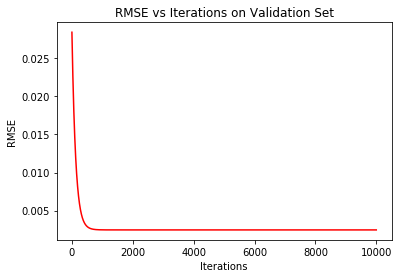

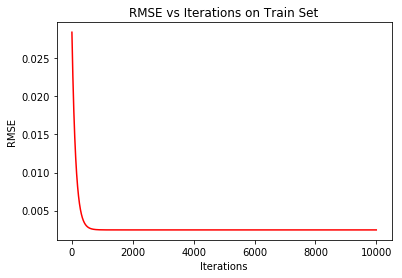

In [75]:
model = LinearRegression(x_splits,y_splits)
gd_train_score,gd_validation_score,theta = model.train(iterations=10000)
# print(gd_train_score,gd_validation_score,theta)

In [76]:
nf_train_score,nf_validation_score,theta = model.fit()
print(nf_train_score, nf_validation_score,theta)

print("Gradient Descend")
print("Train RMSE:",gd_train_score," ; Validation RMSE:",gd_validation_score)
print("Normal Equation")
print("Train RMSE:",nf_train_score," \nValidation RMSE:",nf_validation_score)
print("Train RMSE mean:",nf_train_score.mean()," ; Validation RMSE mean:",nf_validation_score.mean())

[0.00142181 0.00150838 0.00150842 0.0014823  0.00147063] [0.00172245 0.00137605 0.0013751  0.00148529 0.00152608] [[ 0.08162617  0.02400684 -0.02176834  0.17811942  0.9418867   0.84487309
  -0.96126405 -0.32522167  0.32898957]]
Gradient Descend
Train RMSE: 0.0024676287519126506  ; Validation RMSE: 0.002467695229930739
Normal Equation
Train RMSE: [0.00142181 0.00150838 0.00150842 0.0014823  0.00147063]  
Validation RMSE: [0.00172245 0.00137605 0.0013751  0.00148529 0.00152608]
Train RMSE mean: 0.0014783059613952005  ; Validation RMSE mean: 0.001496994118070164


### Normal Equation RMSE < Gradient Descend RMSE


## Regularisation

In [131]:
minfold = np.argmin(nf_validation_score)
print(minfold)
x_csplits, y_csplits = x_splits.copy(), y_splits.copy()
test_X,test_Y = x_csplits.pop(minfold),y_csplits.pop(minfold)
trainval_X,trainval_Y = pd.concat(x_csplits), pd.concat(y_csplits)
def cross_val_split(trainval_X,trainval_Y, folds=5):
    y_splits = np.array_split(trainval_Y, folds)
    x_splits = np.array_split(trainval_X, folds)
    return x_splits,y_splits
x_splits,y_splits = cross_val_split(trainval_X,trainval_Y, folds=5)

2


In [491]:
from sklearn.linear_model import Ridge,Lasso
from sklearn.model_selection import GridSearchCV
alphas = np.array([1,0.1,0.01,0.001,0.0001,0.00001])
print("Ridge L2")
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
grid.fit(trainval_X, trainval_Y)
print(grid)
print("Best score",grid.best_score_)
print("Best estimator",grid.best_estimator_.alpha)
print("Lasso L1")
model = Lasso()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
grid.fit(trainval_X, trainval_Y)
print(grid)
print("Best score",grid.best_score_)
print("Best estimator",grid.best_estimator_.alpha)

Ridge L2
GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
Best score 0.4807807323713393
Best estimator 0.01
Lasso L1
GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=No

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [141]:
class RegLinearRegression:
    def __init__(self,x_in,y_in,folds=5):
        self.x_splits = x_in
        self.y_splits = y_in
        self.theta = np.zeros([1,self.x_splits[0].shape[1]+1])
        self.folds = folds
        
    def train(self,learning_rate=0.00005,iterations=1000,graph=True,regularization=None,penalty=1):
        train_score,validation_score,theta = self.gradientDescend(learning_rate,iterations,regularization,penalty)
        if graph:
            fig2, ax2 = plt.subplots()  
            ax2.set_title("RMSE vs Iterations on Validation Set") 
            ax2.plot(np.arange(iterations), validation_score, 'r')  
            ax2.set_xlabel('Iterations')  
            ax2.set_ylabel('RMSE')
            fig, ax = plt.subplots()
            ax.set_title("RMSE vs Iterations on Train Set") 
            ax.plot(np.arange(iterations), train_score, 'r')  
            ax.set_xlabel('Iterations')  
            ax.set_ylabel('RMSE')
        return train_score[len(train_score)-1],validation_score[len(train_score)-1],self.theta
            
    def fit(self):
        train_folds_score = np.zeros(self.folds)
        validation_folds_score = np.zeros(self.folds)
        for fold in range(0, self.folds):
            x_csplits, y_csplits = x_splits.copy(), y_splits.copy()
            val_X,val_Y = x_csplits.pop(fold),y_csplits.pop(fold)
            train_X,train_Y = pd.concat(x_csplits), pd.concat(y_csplits)
            val_Y, train_Y= val_Y.values.reshape([val_Y.shape[0],1]), train_Y.values.reshape([train_Y.shape[0],1])
            ones = np.ones([train_X.shape[0],1])
            train_X = np.concatenate((ones,train_X),axis=1)
            ones = np.ones([val_X.shape[0],1])
            val_X = np.concatenate((ones,val_X),axis=1)
            a = np.linalg.inv(np.dot(train_X.T,train_X))
            b = np.dot(train_X.T,train_Y)  
            self.theta = np.dot(a,b).T
            train_folds_score[fold]=(self.evaluate(train_X, train_Y))
            validation_folds_score[fold]=(self.evaluate(val_X, val_Y))
        return train_folds_score,validation_folds_score,self.theta
        
    def gradientDescend(self,alpha=0.05,iterations=1000,regularization=None,penalty=1):
        train_score = np.zeros(iterations)
        validation_score = np.zeros(iterations)
        for i in range(iterations):
            train_folds_score = np.zeros(self.folds)
            validation_folds_score = np.zeros(self.folds)
            
            for fold in range(0, self.folds):
                x_csplits, y_csplits = x_splits.copy(), y_splits.copy()
                val_X,val_Y = x_csplits.pop(fold),y_csplits.pop(fold)
                train_X,train_Y = pd.concat(x_csplits), pd.concat(y_csplits)
                val_Y, train_Y= val_Y.values.reshape([val_Y.shape[0],1]), train_Y.values.reshape([train_Y.shape[0],1])
                ones = np.ones([train_X.shape[0],1])
                train_X = np.concatenate((ones,train_X),axis=1)
                ones = np.ones([val_X.shape[0],1])
                val_X = np.concatenate((ones,val_X),axis=1)
                if regularization=='L2':
                    self.theta = self.theta - (alpha/len(train_X)) * (np.sum(train_X.T.dot((train_X @ self.theta.T - train_Y)), axis=0)+penalty*np.sum(np.absolute(self.theta)))
                elif regularization=='L1':
                    self.theta = self.theta - (alpha/len(train_X)) * (np.sum(train_X.T.dot((train_X @ self.theta.T - train_Y)), axis=0)+penalty*np.sum(np.power(self.theta,2)))
                else:
                    self.theta = self.theta - (alpha/len(train_X)) * np.sum(train_X.T.dot((train_X @ self.theta.T - train_Y)), axis=0)         
                train_folds_score[fold]=(self.evaluate(train_X, train_Y))
                validation_folds_score[fold]=(self.evaluate(val_X, val_Y))
            # print(train_folds_score,validation_folds_score)
            train_score[i]=(train_folds_score.mean())
            validation_score[i]=(validation_folds_score.mean())
        return train_score,validation_score,self.theta
        
    def predict(self,x):
        return np.dot(x,self.theta.T)

    def cost(self,X,Y):
        prediction = self.predict(X,self.theta)
        return ((prediction - Y)**2).mean()/2
    
    def rmse(self,X,Y):
        s = np.power(((X @ self.theta.T)-Y),2)
        return (np.sum(s)/(2 * len(X)))*(1/2)
    
    def evaluate(self,test_x, test_y):
        return self.rmse(test_x,test_y)


#### Linear Regression with L2 regularization

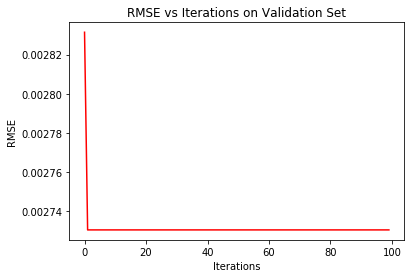

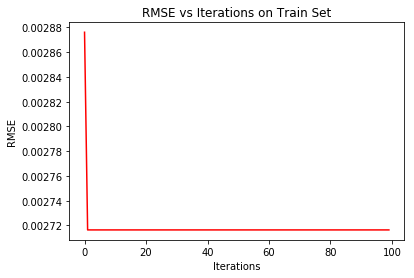

In [142]:
model = RegLinearRegression(x_splits, y_splits, folds=5)
train_score, val_score, _ = model.train(learning_rate=0.01, iterations=100, regularization = 'L2', penalty = 2)
ones = np.ones([test_X.shape[0],1])
test_X_L2 = np.concatenate((ones,test_X),axis=1)
test_Y_L2 = test_Y.values.reshape([test_Y.shape[0],1])
test_score = model.evaluate(test_X_L2,test_Y_L2)

In [143]:
print("Train score",train_score,"Validation Score",val_score,"Test Score",test_score)

Train score 0.002716420479906825 Validation Score 0.00273040873208844 Test Score 0.0030012311145886654


#### Linear Regression with L2 regularization

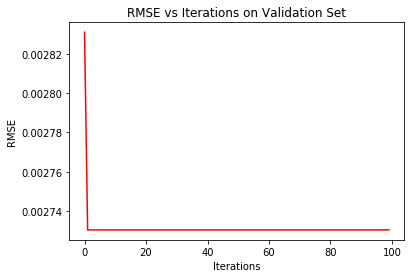

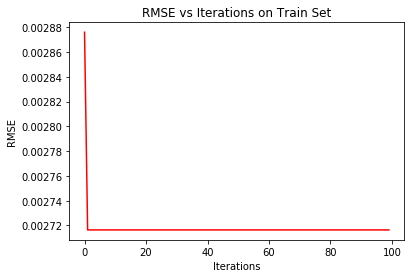

In [145]:
model = RegLinearRegression(x_splits, y_splits, folds=5)
train_score, val_score, _ = model.train(learning_rate=0.05, iterations=100, regularization = 'L1', penalty = 2)
ones = np.ones([test_X.shape[0],1])
test_X_L1 = np.concatenate((ones,test_X),axis=1)
test_Y_L1 = test_Y.values.reshape([test_Y.shape[0],1])
test_score = model.evaluate(test_X_L1,test_Y_L1)

In [136]:
print("Train score",train_score,"Validation Score",val_score,"Test Score",test_score)

Train score 0.002716420479906825 Validation Score 0.00273040873208844 Test Score 0.0030012311145886654


## Best Fit Line

In [478]:
dataset_location = 'bodybrainw/data.csv'
data = pd.read_csv(dataset_location)
# data = (data-data.min())/(data.max()-data.min())
data.head()

,Brain_Weight,Body_Weight
0,1.0,8.429338
1,1.6,10.516225
2,2.2,12.339744
3,2.8,19.217969
4,3.4,19.749753


In [479]:
splits = np.array_split(data, 1)
y_splits = np.array_split(data['Brain_Weight'], 1)
x_splits = np.array_split(data.drop('Brain_Weight',1), 1)
train_x = data['Brain_Weight'].values
train_y = data.drop('Brain_Weight',1).values

In [480]:
class SimpleLinearRegression:
    def __init__ (self, x_in, y_in):
        self.X = x_in
        self.Y = y_in
        self.theta = np.array([[1.0, 1.0]])
    def train(self,learning_rate=0.005,iterations=10000,regularization=None,penalty=1):
        theta = np.array([[1.0, 1.0]])
        self.X = (np.array(self.X).reshape(-1,1))
        ones = np.ones([self.X.shape[0], 1])
        self.X = np.concatenate([ones, self.X],1)
        self.Y = (np.array(self.Y).reshape(-1,1))
        print(self.X.shape,self.Y.shape, regularization,penalty)
        rmse,self.theta = self.gradient_descent(learning_rate, iterations,regularization,penalty)
        print("[m,c]:",self.theta," RMSE:", rmse)
        slope = self.theta[0][0]
        constant = self.theta[0][1]
        return slope,constant

    def predict(self,x):
        slope = self.theta[0][0]
        constant = self.theta[0][1]
        y = slope* x + constant
        return y

    def rmse(self,X,Y):
        s = np.power(((X @ self.theta.T)-Y),2)
        return (np.sum(s)/(2 * len(X)))*(1/2)

    def gradient_descent(self, alpha=0.0005,iterations=1000,regularization=None,penalty=1):
        for i in range(iterations):
            # theta = theta - (alpha/len(X)) * np.sum((X @ theta.T - y) * X, axis=0)
            # print(self.X.shape,self.Y.shape,self.theta.shape,self.theta)
            if regularization=='L2':
                    self.theta = self.theta - (alpha/len(self.X)) * (np.sum((self.X @ self.theta.T - self.Y)* self.X, axis=0)+penalty*np.sum(np.absolute(self.theta)))
            elif regularization=='L1':
                self.theta = self.theta - (alpha/len(self.X)) * (np.sum((self.X @ self.theta.T - self.Y)* self.X, axis=0)+penalty*np.sum(np.power(self.theta,2)))
            else:
                self.theta = self.theta - (alpha/len(self.X)) * np.sum((self.X @ self.theta.T - self.Y)* self.X, axis=0)        
            error = self.rmse(self.X, self.Y)
        return (error,self.theta)


In [481]:
model = SimpleLinearRegression(train_x,train_y)
modell1 = SimpleLinearRegression(train_x,train_y)
modell2 = SimpleLinearRegression(train_x,train_y)

In [482]:
theta = model.train(learning_rate=0.0005,iterations=1000)
thetal1 = modell1.train(learning_rate=0.0005,iterations=1000,regularization='L1',penalty=100)
thetal2 = modell2.train(learning_rate=0.0005,iterations=1000,regularization='L2',penalty=100)

(167, 2) (167, 1) None 1
[m,c]: [[1.48381831 4.6153523 ]]  RMSE: 269.90315523919077
(167, 2) (167, 1) L1 100
[m,c]: [[-7.59255968  4.73682482]]  RMSE: 278.757396860283
(167, 2) (167, 1) L2 100
[m,c]: [[0.05699742 4.63586253]]  RMSE: 270.60416385762323


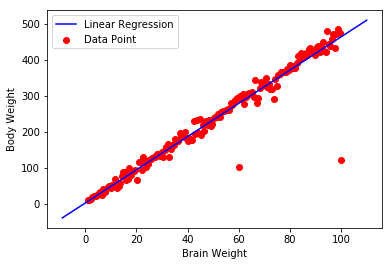

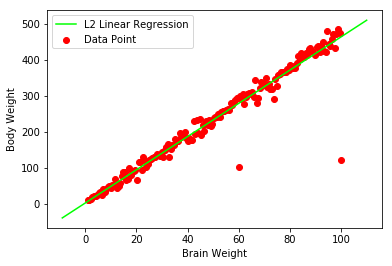

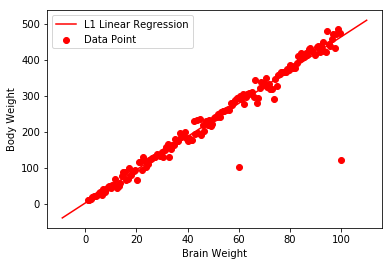

In [483]:
b0,b1=theta[0],theta[1]
b0l1,b1l1=thetal1[0],thetal1[1]
b0l2,b1l2=thetal2[0],thetal2[1]
x_max = np.max(train_x) + 10
x_min = np.min(train_x) - 10
x = np.linspace(x_min, x_max, 1000)
y = b0 + b1 * x
yl1 = b0l1 + b1l1 * x
yl2 = b0l2 + b1l2 * x
plt.plot(x, y, color='#0000ff', label='Linear Regression')
plt.scatter(train_x, train_y, color='#ff0000', label='Data Point')
plt.xlabel('Brain Weight')
plt.ylabel('Body Weight')
plt.legend()
plt.show()
plt.plot(x, y, color='#00ff00', label='L2 Linear Regression')
plt.scatter(train_x, train_y, color='#ff0000', label='Data Point')
plt.xlabel('Brain Weight')
plt.ylabel('Body Weight')
plt.legend()
plt.show()
plt.plot(x, y, color='#ff0000', label='L1 Linear Regression')
plt.scatter(train_x, train_y, color='#ff0000', label='Data Point')
plt.xlabel('Brain Weight')
plt.ylabel('Body Weight')
plt.legend()
plt.show()

## Non regularized line was the best fit among the three in train set and has lowest RMSE, but the model would probable overfit.
## In real world scenario L1 regularisation might be better